In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

df = pd.read_csv('/content/drive/MyDrive/malicious_url.csv')
df = df.dropna(subset=["url"]).drop_duplicates(subset=["url"])
X = df['url']
y = df['type']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

def clean_url(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc.lower()
    domain = re.sub(r"^(www\.)?", "", domain)
    path = parsed_url.path
    cleaned_url = domain + path
    cleaned_url = re.sub(r"\?.*", "", cleaned_url)
    cleaned_url = re.sub(r"#.*", "", cleaned_url)
    cleaned_url = re.sub(r"/+", "/", cleaned_url).rstrip("/")
    return cleaned_url

X_cleaned = X.apply(clean_url)

X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

models = {
    "Decision Tree": (DecisionTreeClassifier(), {
        "criterion": ["gini", "entropy"],
        "max_depth": [10, 20, 30, None]
    }),
    "Random Forest": (RandomForestClassifier(), {
        "n_estimators": [100, 200, 300, 400],
        "max_depth": [10, 20, 30, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }),
    "Extra Trees": (ExtraTreesClassifier(), {
        "n_estimators": [100, 200, 300, 400],
        "max_depth": [10, 20, 30, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    }),
    "Gradient Boosting": (GradientBoostingClassifier(), {
        "n_estimators": [100, 200, 300, 400],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "max_depth": [3, 5, 7, 10]
    }),
    "XGBoost": (XGBClassifier(eval_metric='mlogloss'), {
        "n_estimators": [100, 200, 300, 400],
        "max_depth": [3, 5, 7, 10],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "subsample": [0.6, 0.8, 1.0]
    }),
    "LightGBM": (LGBMClassifier(verbose=-1), {
        "n_estimators": [100, 200, 300, 400],
        "max_depth": [-1, 10, 20],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "num_leaves": [20, 30, 40, 50],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0]
    }),
    "SVM": (SVC(), {
        "C": [0.1, 1, 10, 100],
        "gamma": [0.001, 0.01, 0.1, 1],
        "kernel": ["rbf", "linear"]
    })
}
best_models = {}

for name, (model, param_grid) in models.items():
    print(f"Tuning {name}...")

    pipeline = Pipeline([
        ("scaler", MaxAbsScaler()),
        ("classifier", model)
    ])

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions={ "classifier__" + key: value for key, value in param_grid.items() },
        n_iter=20,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    random_search.fit(X_train_tfidf, y_train)
    best_models[name] = random_search.best_estimator_

    train_pred = best_models[name].predict(X_train_tfidf)
    train_accuracy = accuracy_score(y_train, train_pred)

    test_pred = best_models[name].predict(X_test_tfidf)
    test_accuracy = accuracy_score(y_test, test_pred)

    print(f"Best {name} Parameters: {random_search.best_params_}")
    print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%\n")

Tuning Decision Tree...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Decision Tree Parameters: {'classifier__max_depth': None, 'classifier__criterion': 'gini'}
Training Accuracy: 97.03%
Testing Accuracy: 91.16%

Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Random Forest Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None}
Training Accuracy: 96.76%
Testing Accuracy: 92.03%

Tuning Extra Trees...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Extra Trees Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None}
Training Accuracy: 96.94%
Testing Accuracy: 92.80%

Tuning Gradient Boosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Gradient Boosting Parameters: {'classifier__n_estimators': 200, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.2}
Training Accuracy: 97.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best LightGBM Parameters: {'classifier__subsample': 0.8, 'classifier__num_leaves': 50, 'classifier__n_estimators': 100, 'classifier__max_depth': -1, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.6}
Training Accuracy: 93.74%
Testing Accuracy: 89.99%

Tuning SVM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best SVM Parameters: {'classifier__kernel': 'linear', 'classifier__gamma': 1, 'classifier__C': 1}
Training Accuracy: 95.42%
Testing Accuracy: 92.23%



Evaluating Decision Tree...

🔹 Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      2199
           1       0.90      0.85      0.87       545
           2       0.87      0.75      0.81        61
           3       0.77      0.45      0.57       182

    accuracy                           0.91      2987
   macro avg       0.86      0.76      0.80      2987
weighted avg       0.91      0.91      0.91      2987

Evaluating Random Forest...

🔹 Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2199
           1       0.94      0.84      0.89       545
           2       0.94      0.74      0.83        61
           3       0.83      0.46      0.59       182

    accuracy                           0.92      2987
   macro avg       0.91      0.76      0.81      2987
weighted avg       0.92      0.92      

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2199
           1       0.91      0.79      0.84       545
           2       0.81      0.57      0.67        61
           3       0.72      0.43      0.54       182

    accuracy                           0.90      2987
   macro avg       0.84      0.69      0.75      2987
weighted avg       0.89      0.90      0.89      2987

Evaluating SVM...

🔹 Classification Report for SVM:

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2199
           1       0.93      0.87      0.90       545
           2       0.96      0.70      0.81        61
           3       0.78      0.44      0.56       182

    accuracy                           0.92      2987
   macro avg       0.90      0.75      0.81      2987
weighted avg       0.92      0.92      0.92      2987



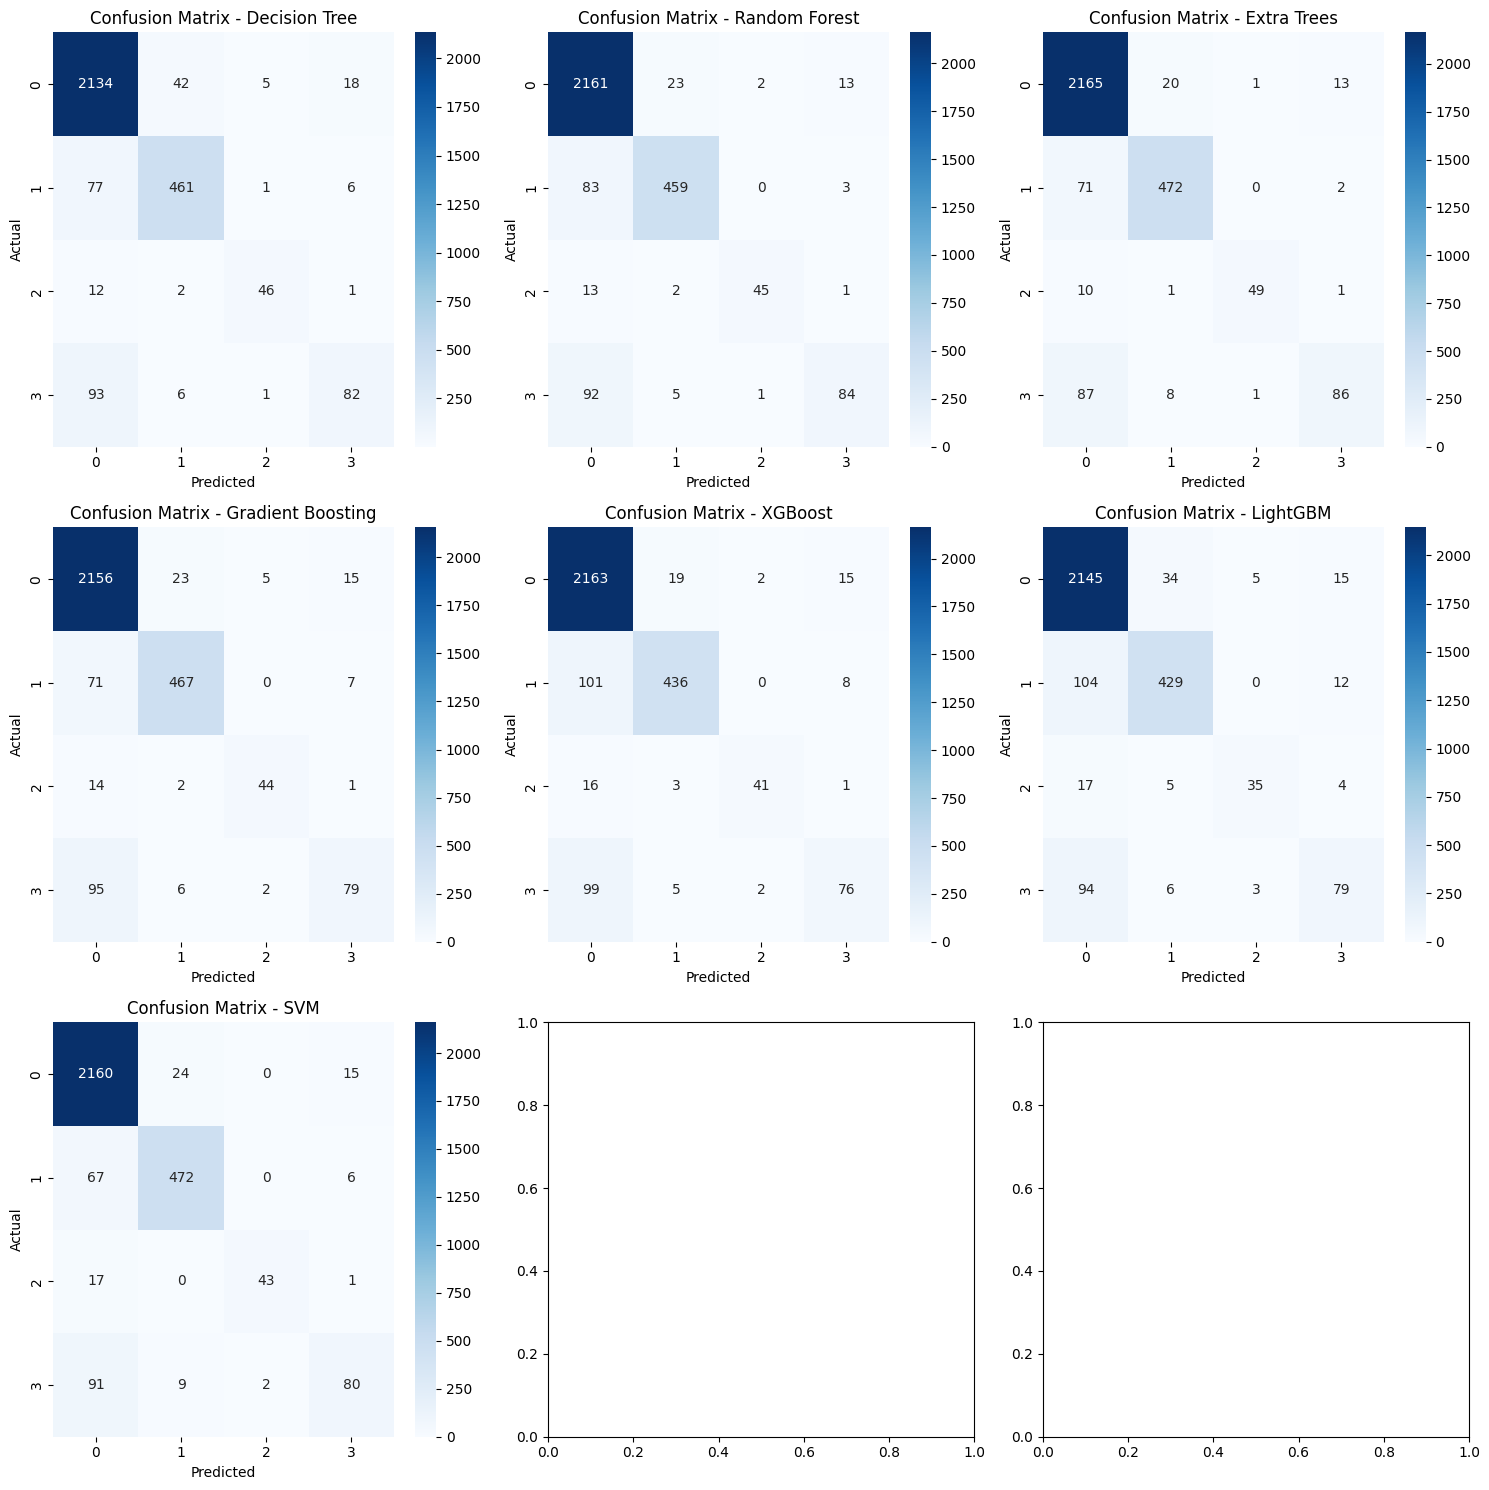

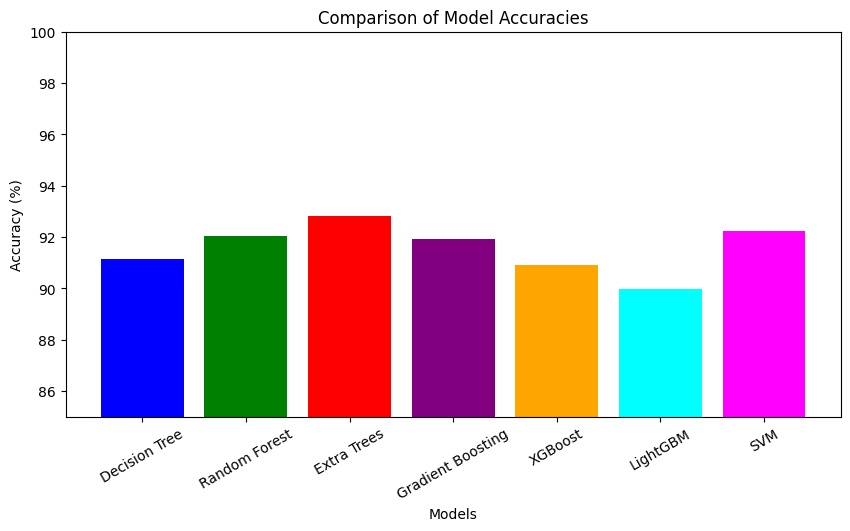

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model_accuracies = {}

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, (model_name, model) in enumerate(best_models.items()):
    print(f"Evaluating {model_name}...\n")

    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[model_name] = accuracy * 100

    print(f"🔹 Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"Confusion Matrix - {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.draw()
plt.pause(1)
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color=['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta'])
plt.ylabel("Accuracy (%)")
plt.xlabel("Models")
plt.title("Comparison of Model Accuracies")
plt.ylim(85, 100)
plt.xticks(rotation=30)
plt.show()
